# Regression lineare su grigli pixel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

t       x       y      z  layer_id  sensor0  sensor1    temp  \
0  80444000.0  26.048 -66.325  21.12       528    801.0    798.0  1591.9   
1  80444010.0  26.054 -66.332  21.12       528    803.0    798.0  1594.6   
2  80444020.0  26.061 -66.338  21.12       528    789.0    785.0  1593.3   
3  80444030.0  26.063 -66.342  21.12       528    785.0    790.0  1580.7   
4  80444040.0  26.066 -66.345  21.12       528    785.0    790.0  1580.7   

   track_id  track_orient  pos_rel  t_rel  
0         0           119  0.00000    0.0  
1         0           119  0.00816   10.0  
2         0           119  0.01633   20.0  
3         0           119  0.02449   30.0  
4         0           119  0.03265   40.0

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [3]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_35471/437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_35471/437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


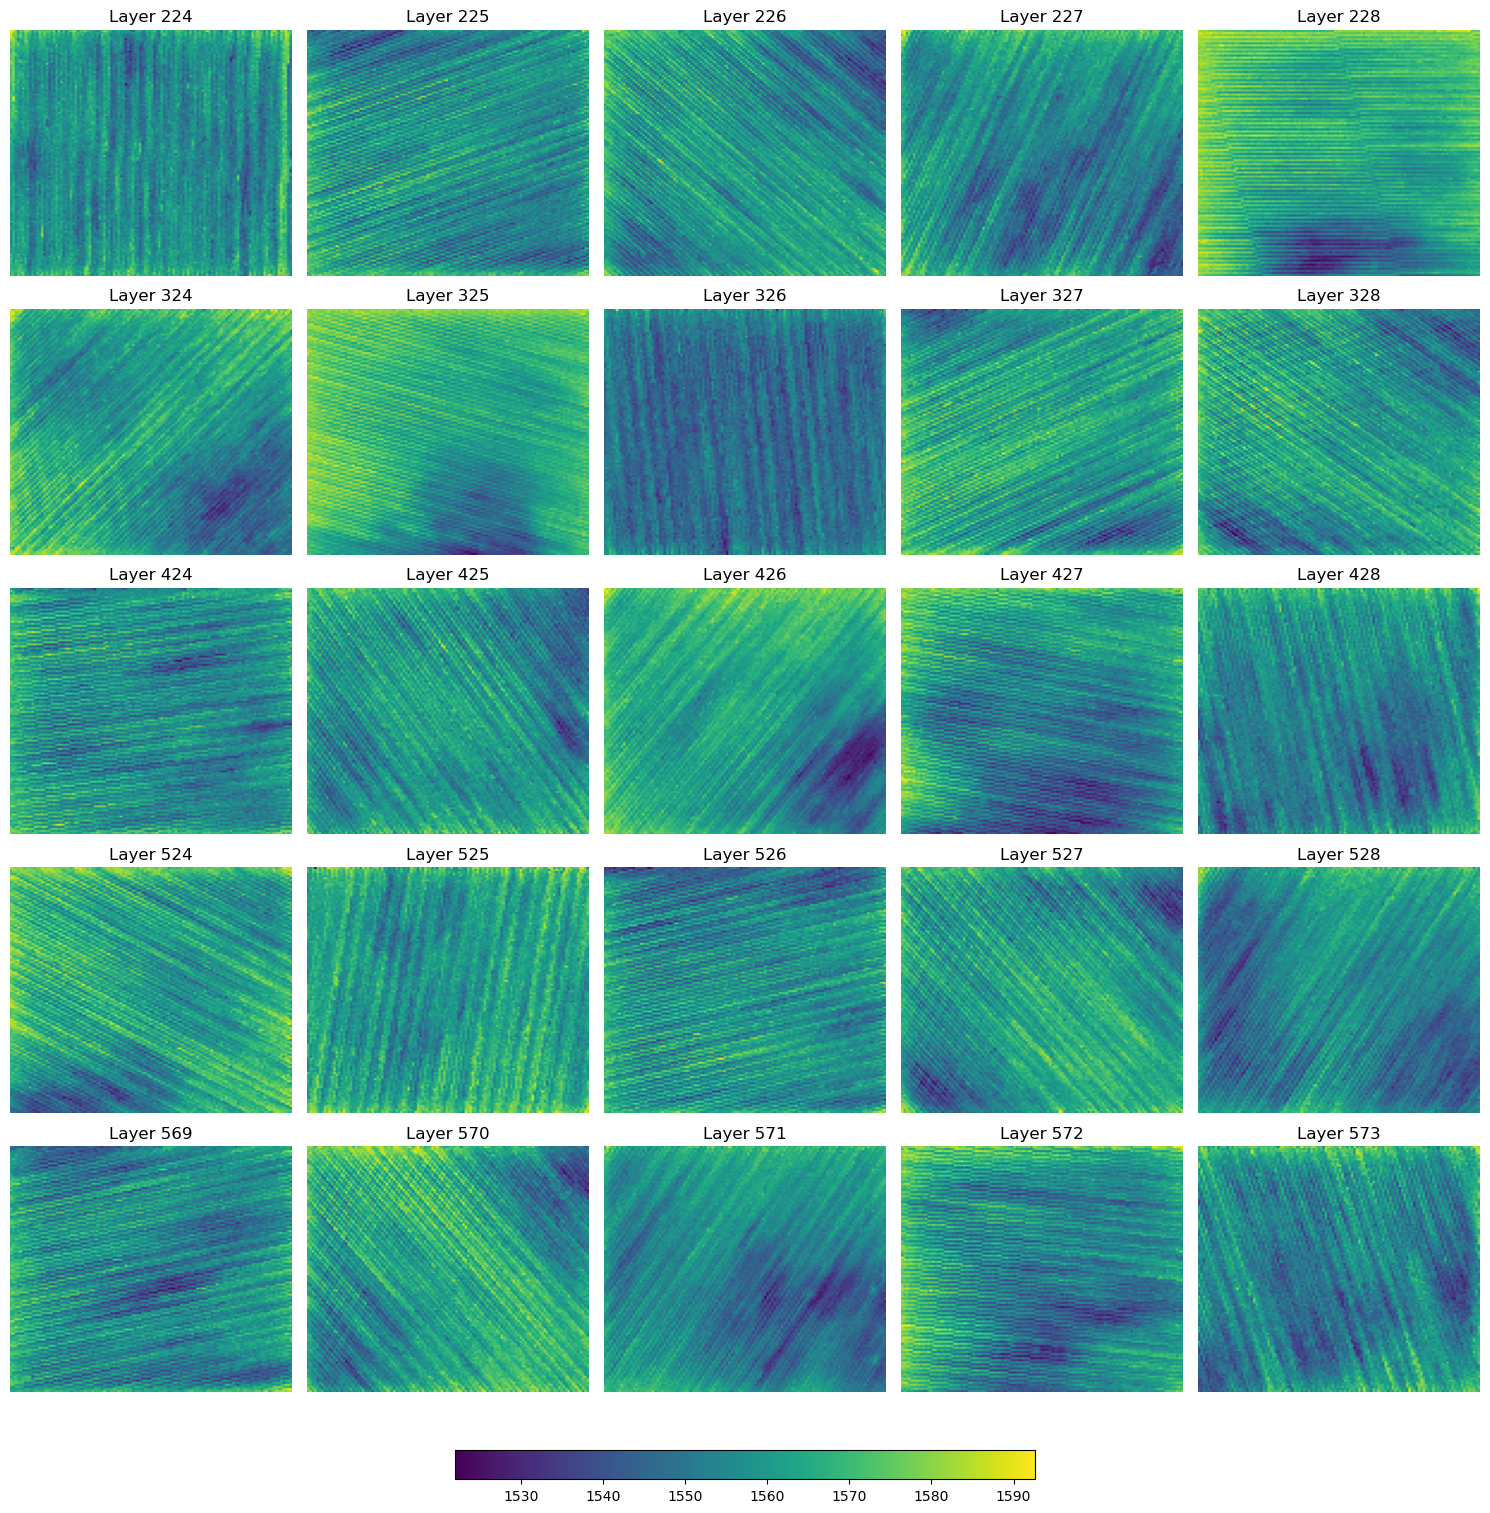

In [31]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, layer in enumerate(list_25l):
    im = axes[i].imshow(layer, aspect='auto', cmap='viridis')
    axes[i].set_title(f'Layer {layer_ids[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

In [32]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the list_25l instead of the original dataset
X = []
y = []

for layer_index, pivot_table in enumerate(list_25l):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = pd.DataFrame(X, columns=['layer_id', 'x', 'y'])
y = pd.Series(y, name='temp')
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
temp =  + 1563.124 const -0.120 layer_id -0.073 x -0.060 y

COEFFICIENTS
------------
    Term      Coef  SE Coef    T-Value     P-Value
   const 1563.1240   0.0822 19009.9089  0.0000e+00
layer_id   -0.1203   0.0037   -32.7963 1.5056e-235
       x   -0.0734   0.0008   -96.0884  0.0000e+00
       y   -0.0602   0.0008   -77.5801  0.0000e+00

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
15.7333 0.0441     0.0441

ANALYSIS OF VARIANCE
---------------------
    Source       DF     Adj SS     Adj MS    F-Value     P-Value
Regression      3.0 4.0416e+06 1.3472e+06 5.4424e+03  0.0000e+00
     const      1.0 8.9454e+10 8.9454e+10 3.6138e+08  0.0000e+00
  layer_id      1.0 2.6625e+05 2.6625e+05 1.0756e+03 1.5056e-235
         x      1.0 2.2855e+06 2.2855e+06 9.2330e+03  0.0000e+00
         y      1.0 1.4898e+06 1.4898e+06 6.0187e+03  0.0000e+00
     Error 353996.0 8.7627e+07 2.4754e+02        NaN         NaN
     Total 353999.0 9.1668e+07        N

In [33]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the original dataset
X = df[['layer_id', 'x', 'y']]
y = df['temp']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
qda.summary(model)



REGRESSION EQUATION
-------------------
temp =  + 1533.881 const -0.002 layer_id -0.685 x -0.711 y

COEFFICIENTS
------------
    Term      Coef    SE Coef   T-Value     P-Value
   const 1533.8815 1.7274e-01 8879.4637  0.0000e+00
layer_id   -0.0017 6.8100e-05  -25.2501 1.1566e-140
       x   -0.6854 2.4847e-03 -275.8251  0.0000e+00
       y   -0.7108 2.4805e-03 -286.5491  0.0000e+00

MODEL SUMMARY
-------------
      S  R-sq  R-sq(adj)
18.3565 0.034      0.034

ANALYSIS OF VARIANCE
---------------------
    Source        DF     Adj SS     Adj MS    F-Value     P-Value
Regression       3.0 5.3527e+07 1.7842e+07 5.2951e+04  0.0000e+00
     const       1.0 2.6568e+10 2.6568e+10 7.8845e+07  0.0000e+00
  layer_id       1.0 2.1483e+05 2.1483e+05 6.3757e+02 1.1566e-140
         x       1.0 2.5636e+07 2.5636e+07 7.6079e+04  0.0000e+00
         y       1.0 2.7668e+07 2.7668e+07 8.2110e+04  0.0000e+00
     Error 4512002.0 1.5204e+09 3.3696e+02        NaN         NaN
     Total 4512005.0 1.5739e+

In [34]:
# Get the residuals
residuals = model.resid

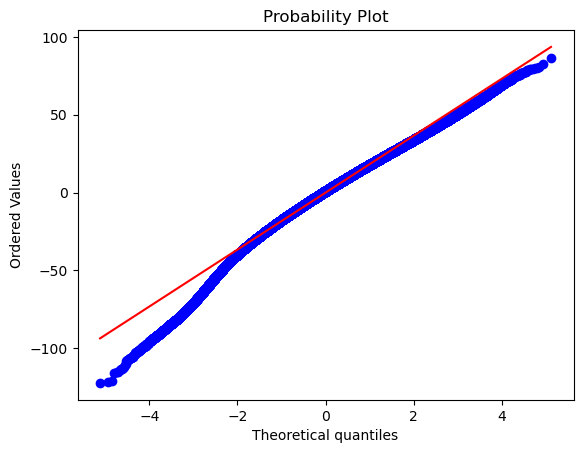

Shapiro-wilk test statistic = 0.996
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [35]:
# Check the normality of the residuals
_ = qda.Assumptions(residuals).normality()

In [36]:
# Check the randomness of the residuals
_ = qda.Assumptions(residuals).independence()

: 

: 

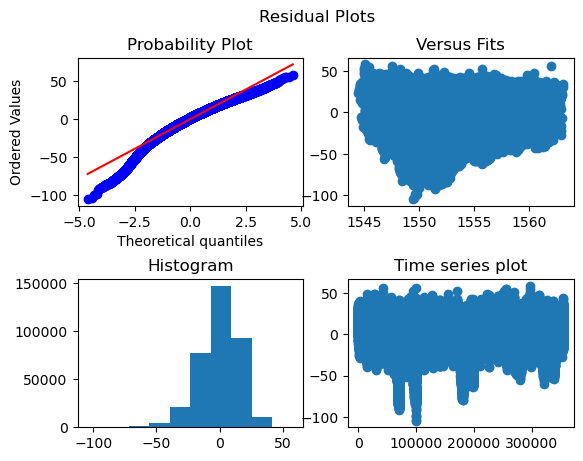

In [ ]:
#NORMALITY OF RESIDUALS
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(residuals, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(model.fittedvalues, residuals)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(residuals)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')


# Batching 60x60

In [ ]:
# Create a reduced dataset by taking 1 value every 3 along each axis
reduced_dataset = list_25l[:, ::2, ::2]
print(reduced_dataset.shape)
reduced_dataset

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 2.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qda-toolkit 0.1.4 requires numpy==1.21.5, but you have numpy 2.0.2 which is incompatible.
qda-toolkit 0.

array([[[1595.9904, 1583.6804, 1585.0085, ..., 1574.9177, 1576.8345,
         1579.8271],
        [1591.3017, 1582.0217, 1581.1115, ..., 1570.27  , 1571.9365,
         1584.5189],
        [1583.6825, 1576.2427, 1574.1788, ..., 1567.945 , 1574.0632,
         1583.4995],
        ...,
        [1574.3123, 1575.6527, 1573.8712, ..., 1573.555 , 1579.7957,
         1563.8418],
        [1573.6995, 1573.5018, 1575.233 , ..., 1576.421 , 1584.6983,
         1568.2749],
        [1575.2022, 1570.6491, 1574.2332, ..., 1583.5077, 1586.9793,
         1575.4085]],

       [[1554.8581, 1539.7505, 1546.225 , ..., 1569.933 , 1566.8633,
         1581.2688],
        [1556.2467, 1549.552 , 1558.2752, ..., 1574.5283, 1571.0336,
         1571.5702],
        [1561.4575, 1555.8805, 1559.075 , ..., 1566.3038, 1567.812 ,
         1569.1743],
        ...,
        [1580.018 , 1578.4382, 1577.2075, ..., 1547.98  , 1558.4792,
         1542.879 ],
        [1581.287 , 1579.7942, 1575.3155, ..., 1555.7705, 1565.7892,
   

In [8]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the list_25l instead of the original dataset
X = []
y = []

for layer_index, pivot_table in enumerate(reduced_dataset):
    pivot_df_rd = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df_rd.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = pd.DataFrame(X, columns=['layer_id', 'x', 'y'])
y = pd.Series(y, name='temp')
X = sm.add_constant(X)

model2 = sm.OLS(y, X).fit()
qda.summary(model2)

REGRESSION EQUATION
-------------------
temp =  + 1562.769 const -0.096 layer_id -0.151 x -0.119 y

COEFFICIENTS
------------
    Term      Coef  SE Coef   T-Value    P-Value
   const 1562.7688   0.1649 9479.3142 0.0000e+00
layer_id   -0.0959   0.0074  -12.9808 1.7054e-38
       x   -0.1510   0.0031  -49.0589 0.0000e+00
       y   -0.1188   0.0031  -37.9646 0.0000e+00

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
15.8531 0.0434     0.0434

ANALYSIS OF VARIANCE
---------------------
    Source      DF     Adj SS     Adj MS    F-Value     P-Value
Regression     3.0 1.0094e+06 3.3648e+05 1.3389e+03  0.0000e+00
     const     1.0 2.2583e+10 2.2583e+10 8.9857e+07  0.0000e+00
  layer_id     1.0 4.2348e+04 4.2348e+04 1.6850e+02  1.7054e-38
         x     1.0 6.0487e+05 6.0487e+05 2.4068e+03  0.0000e+00
         y     1.0 3.6223e+05 3.6223e+05 1.4413e+03 7.4142e-313
     Error 88496.0 2.2241e+07 2.5132e+02        NaN         NaN
     Total 88499.0 2.3250e+07        NaN        NaN     

In [10]:
# Get the residuals
residuals2 = model2.resid


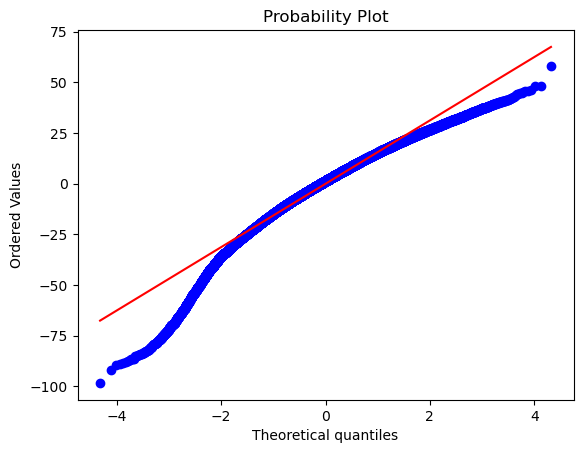

Shapiro-wilk test statistic = 0.973
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
# Check the normality of the residuals
_ = qda.Assumptions(residuals2).normality()

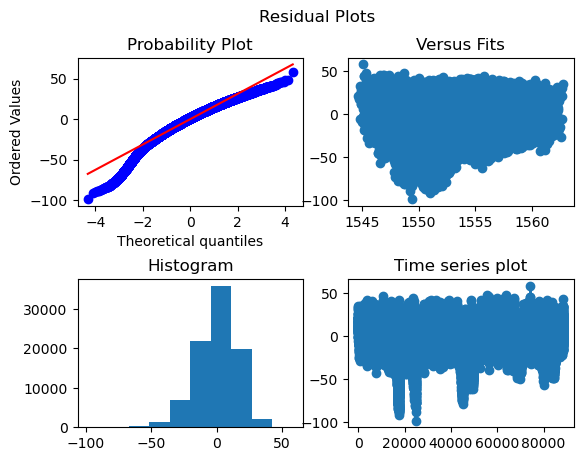

In [13]:
#NORMALITY OF RESIDUALS
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(residuals2, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(model2.fittedvalues, residuals2)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(residuals2)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(residuals2)+1), residuals2, 'o-')


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = []
y = []

for layer_index, pivot_table in enumerate(reduced_dataset):
    pivot_df_rd = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df_rd.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 74.97297194718706


In [19]:
# qda.summary() is not applicable for RandomForestRegressor. 
# If you want to evaluate the RandomForestRegressor, you can use metrics like mean squared error or feature importance.
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 74.97297194718706


In [20]:
# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse}")

# Evaluate the model on the testing set
test_mse = mean_squared_error(y_test, y_pred)
print(f"Testing Mean Squared Error: {test_mse}")

# Calculate R-squared for the testing set
test_r2 = model.score(X_test, y_test)
print(f"Testing R-squared: {test_r2}")

# Feature importance (specific to RandomForestRegressor)
feature_importances = model.feature_importances_
print(f"Feature Importances: {feature_importances}")

Training Mean Squared Error: 10.245653662007747
Testing Mean Squared Error: 74.97297194718706
Testing R-squared: 0.715754618017735
Feature Importances: [0.3578 0.3237 0.3185]


In [22]:
n = X_test.shape[0]  # Number of observations
k = X_test.shape[1] - 1  # Number of predictors (excluding the intercept)

adjusted_r2 = 1 - ((1 - test_r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R-squared: {adjusted_r2}")

Adjusted R-squared: 0.7157224944508047


In [16]:
# Calculate residuals for the RandomForestRegressor
residual3 = y_test - y_pred


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


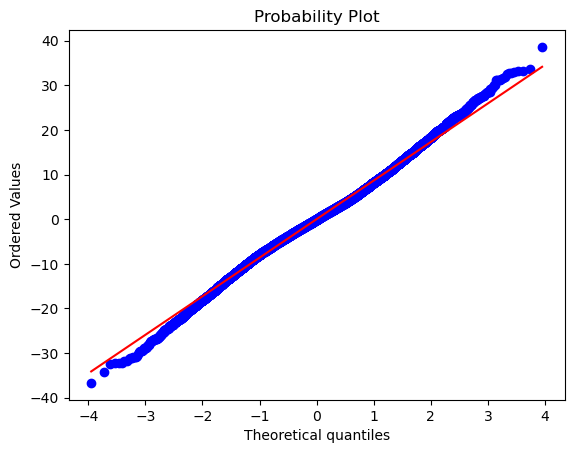

Shapiro-wilk test statistic = 0.995
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [17]:
_=qda.Assumptions(residual3).normality()


In [ ]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result = anderson(residual3, dist='norm')

print("Anderson-Darling Test Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

# Interpret the result
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 26.94786206603385
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


# Batchin 50x50


In [28]:
# Install scikit-image if not already installed
%pip install scikit-image

from skimage.transform import resize

# Ensure reduced_dataset is defined
if 'reduced_dataset' not in locals():
	reduced_dataset = np.random.rand(10, 100, 100)  # Example placeholder dataset

# Reshape each layer to 50x50 using batching
resized_dataset = np.array([resize(layer, (50, 50), anti_aliasing=True) for layer in reduced_dataset])
print(resized_dataset.shape)
resized_dataset

  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
error: uninstall-no-record-file

× Cannot uninstall numpy 1.21.5
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==1.21.5
Note: you may need to restart the kernel to use updated packages.
(25, 50, 50)


array([[[1595.9904, 1583.6804, 1585.0085, ..., 1574.9177, 1576.8345,
         1579.8271],
        [1591.3017, 1582.0217, 1581.1115, ..., 1570.27  , 1571.9365,
         1584.5189],
        [1583.6825, 1576.2427, 1574.1788, ..., 1567.945 , 1574.0632,
         1583.4995],
        ...,
        [1574.3123, 1575.6527, 1573.8712, ..., 1573.555 , 1579.7957,
         1563.8418],
        [1573.6995, 1573.5018, 1575.233 , ..., 1576.421 , 1584.6983,
         1568.2749],
        [1575.2022, 1570.6491, 1574.2332, ..., 1583.5077, 1586.9793,
         1575.4085]],

       [[1554.8581, 1539.7505, 1546.225 , ..., 1569.933 , 1566.8633,
         1581.2688],
        [1556.2467, 1549.552 , 1558.2752, ..., 1574.5283, 1571.0336,
         1571.5702],
        [1561.4575, 1555.8805, 1559.075 , ..., 1566.3038, 1567.812 ,
         1569.1743],
        ...,
        [1580.018 , 1578.4382, 1577.2075, ..., 1547.98  , 1558.4792,
         1542.879 ],
        [1581.287 , 1579.7942, 1575.3155, ..., 1555.7705, 1565.7892,
   

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = []
y = []

for layer_index, pivot_table in enumerate(resized_dataset):
    pivot_df_rrd = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df_rrd.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor
model4 = RandomForestRegressor(n_estimators=100, random_state=42)
model4.fit(X_train, y_train)

# Predict and evaluate the model
y_pred2 = model4.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred2)
print(f"Mean Squared Error: {mse2}")

Mean Squared Error: 33.89721515305983


In [30]:
# Evaluate the model on the training set
y_train_pred = model4.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse2}")

# Evaluate the model on the testing set
test_mse2 = mean_squared_error(y_test, y_pred2)
print(f"Testing Mean Squared Error: {test_mse2}")

# Calculate R-squared for the testing set
test_r22 = model4.score(X_test, y_test)
print(f"Testing R-squared: {test_r22}")

# Feature importance (specific to RandomForestRegressor)
feature_importances = model4.feature_importances_
print(f"Feature Importances: {feature_importances}")

Training Mean Squared Error: 4.648710612901005
Testing Mean Squared Error: 33.89721515305983
Testing R-squared: 0.8494169073175586
Feature Importances: [0.4199 0.2963 0.2838]


In [31]:
# Calculate residuals for the RandomForestRegressor
residual4= y_test - y_pred2


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


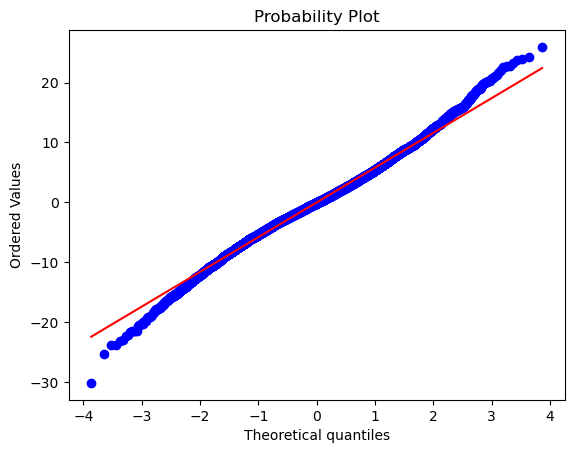

Shapiro-wilk test statistic = 0.994
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [32]:
_=qda.Assumptions(residual4).normality()


In [33]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result2 = anderson(residual4, dist='norm')

print("Anderson-Darling Test Statistic:", result2.statistic)
print("Critical Values:", result2.critical_values)
print("Significance Levels:", result2.significance_level)

# Interpret the result
for i in range(len(result2.critical_values)):
    sl, cv = result2.significance_level[i], result2.critical_values[i]
    if result2.statistic < cv:
        print(f"At {sl}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 20.948703235348148
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


# Random Batching

In [97]:
import random

# Ensure list_25l is defined
if 'list_25l' not in locals():
    list_25l = np.random.rand(10, 100, 100)  # Example placeholder dataset

# Function to randomly sample a 60x60 region from each layer
def random_sampling_60x60(dataset, target_dim=(60, 60)):
    sampled_dataset = []
    for layer in dataset:
        max_x = layer.shape[0] - target_dim[0]
        max_y = layer.shape[1] - target_dim[1]
        
        # Randomly select the starting indices
        start_x = random.randint(0, max_x)
        start_y = random.randint(0, max_y)
        
        # Extract the 60x60 region
        sampled_layer = layer[start_x:start_x + target_dim[0], start_y:start_y + target_dim[1]]
        sampled_dataset.append(sampled_layer)
    
    return np.array(sampled_dataset)

# Create the random sampling
random_sampled_dataset = random_sampling_60x60(list_25l)
print(random_sampled_dataset.shape)
random_sampled_dataset

(25, 60, 60)


array([[[1566.2 , 1571.65, 1576.4 , ..., 1566.4 , 1557.55, 1553.4 ],
        [1560.6 , 1573.45, 1555.35, ..., 1563.25, 1555.35, 1556.75],
        [1564.6 , 1571.6 , 1548.7 , ..., 1555.8 , 1563.9 , 1555.95],
        ...,
        [1590.2 , 1553.8 , 1559.3 , ..., 1556.85, 1563.8 , 1566.  ],
        [1587.7 , 1559.1 , 1560.6 , ..., 1553.2 , 1567.6 , 1563.7 ],
        [1570.7 , 1556.8 , 1557.95, ..., 1558.7 , 1568.15, 1567.85]],

       [[1584.  , 1553.5 , 1544.25, ..., 1562.3 , 1564.  , 1564.45],
        [1547.8 , 1576.  , 1566.6 , ..., 1562.8 , 1557.7 , 1559.3 ],
        [1569.65, 1562.4 , 1550.7 , ..., 1563.5 , 1570.6 , 1563.4 ],
        ...,
        [1564.9 , 1551.6 , 1572.8 , ..., 1560.65, 1539.3 , 1539.2 ],
        [1576.6 , 1580.15, 1560.3 , ..., 1536.55, 1548.2 , 1560.8 ],
        [1560.2 , 1552.1 , 1555.1 , ..., 1561.05, 1569.2 , 1549.8 ]],

       [[1545.  , 1580.2 , 1561.1 , ..., 1541.1 , 1555.6 , 1533.9 ],
        [1543.9 , 1550.1 , 1587.7 , ..., 1539.45, 1545.3 , 1559.1 ],
    

In [35]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the list_25l instead of the original dataset
X = []
y = []

for layer_index, pivot_table in enumerate(random_sampled_dataset):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = pd.DataFrame(X, columns=['layer_id', 'x', 'y'])
y = pd.Series(y, name='temp')
X = sm.add_constant(X)

model2 = sm.OLS(y, X).fit()
qda.summary(model2)

REGRESSION EQUATION
-------------------
temp =  + 1558.702 const -0.111 layer_id -0.117 x -0.072 y

COEFFICIENTS
------------
    Term      Coef  SE Coef   T-Value     P-Value
   const 1558.7019   0.1632 9552.4019  0.0000e+00
layer_id   -0.1112   0.0073  -15.2058  3.7577e-52
       x   -0.1166   0.0030  -38.2991  0.0000e+00
       y   -0.0725   0.0030  -23.8026 7.6552e-125

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
15.8219 0.0245     0.0245

ANALYSIS OF VARIANCE
---------------------
    Source      DF     Adj SS     Adj MS    F-Value     P-Value
Regression     3.0 5.6690e+05 1.8897e+05 7.5487e+02  0.0000e+00
     const     1.0 2.2842e+10 2.2842e+10 9.1248e+07  0.0000e+00
  layer_id     1.0 5.7881e+04 5.7881e+04 2.3122e+02  3.7577e-52
         x     1.0 3.6719e+05 3.6719e+05 1.4668e+03 2.3662e-318
         y     1.0 1.4183e+05 1.4183e+05 5.6656e+02 7.6552e-125
     Error 89996.0 2.2529e+07 2.5033e+02        NaN         NaN
     Total 89999.0 2.3096e+07        NaN        NaN

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = []
y = []

for layer_index, pivot_table in enumerate(random_sampled_dataset):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse= mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 94.0985849154584


In [37]:
# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse}")

# Evaluate the model on the testing set
test_mse = mean_squared_error(y_test, y_pred)
print(f"Testing Mean Squared Error: {test_mse}")

# Calculate R-squared for the testing set
test_r = model.score(X_test, y_test)
print(f"Testing R-squared: {test_r}")

# Feature importance (specific to RandomForestRegressor)
feature_importances = model.feature_importances_
print(f"Feature Importances: {feature_importances}")

Training Mean Squared Error: 11.422389625656189
Testing Mean Squared Error: 82.18318820584733
Testing R-squared: 0.6788230963771998
Feature Importances: [0.5073 0.257  0.2358]


In [99]:
# Calculate residuals for the RandomForestRegressor
residual= y_test - y_pred


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


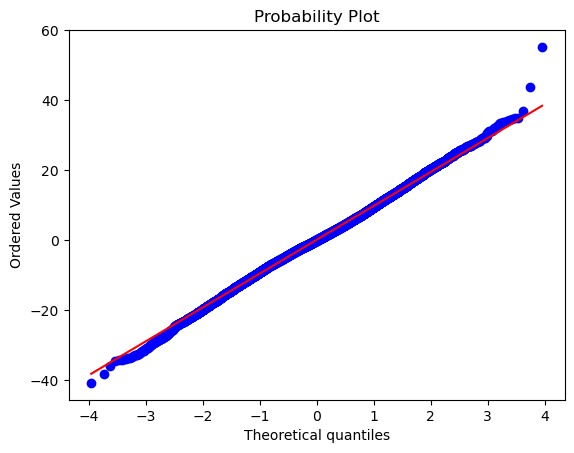

Shapiro-wilk test statistic = 0.998
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [100]:
_=qda.Assumptions(residual).normality()


In [101]:
from scipy.stats import zscore

# Calculate the z-scores for the residuals
z_scores = zscore(residuals)

# Define a threshold for identifying outliers
z_threshold = 3

# Identify the indices of residuals that are outliers
outlier_indices = np.where(np.abs(z_scores) > z_threshold)[0]

# Print the outliers
print(f"Outlier Indices: {outlier_indices}")
print(f"Outlier Residuals: {residuals[outlier_indices]}")

Outlier Indices: [   36   316   426   811  1348  1803  1885  1927  2075  2259  2546  3271
  3718  3744  4244  4542  4602  5049  5062  5140  5228  5236  5264  5416
  5886  6090  6253  6636  7274  7394  8083  8423  8924  9036  9231  9635
  9729  9735 10117 10591 10650 10896 10911 10946 11191 11206 11207 11436
 11505 12431 12913 13155 13208 13368 14417 14688 14825 14881 15024 15219
 15497 15983 16607 16780 16836 17266]
Outlier Residuals: [ 32.7115 -36.118  -34.982   33.175   33.6535  33.086   34.2615  33.126
 -32.655  -34.2575  36.659   37.7785 -37.781   32.031  -45.667  -32.893
  33.762  -33.562  -32.9925 -34.4475  35.8475  39.105  -32.12    36.4525
 -33.724   32.2615  33.1165  33.546   31.796   32.8105  32.8575  34.0625
  35.2865 -33.2775  35.586   33.789   32.23    31.7665  31.522   32.929
 -32.1305 -33.022  -36.6055  32.832   32.512  -33.2085 -34.781   35.437
  37.0665 -31.7525  31.927   31.9305  33.5955 -31.4785  36.8725  31.8185
 -32.8745 -33.7295 -35.2775  40.575  -31.685  -35.024 

In [103]:
# Define the points to remove
points_to_remove = [(layer_index, x_coord, y_coord)]  # Replace with the actual points you want to remove

# Update the batched_dataset by setting the specified points to np.nan
for layer_index, x, y in points_to_remove:
    random_sampled_dataset[layer_index, x, y] = np.nan

print("Specified points have been removed (set to NaN) in random_sampled_dataset.")

Specified points have been removed (set to NaN) in random_sampled_dataset.


In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = []
y = []

for layer_index, pivot_table in enumerate(random_sampled_dataset):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse= mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 93.84331787255547


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


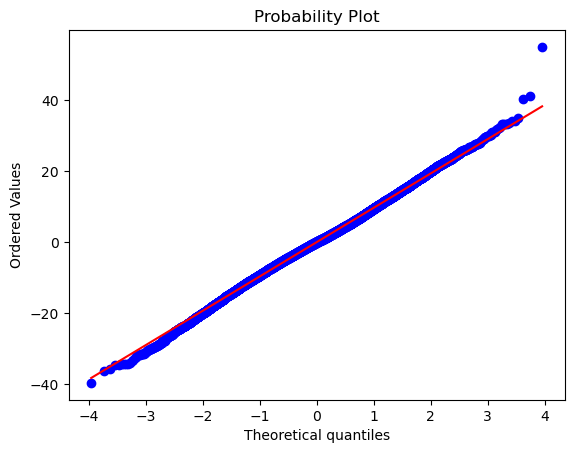

Shapiro-wilk test statistic = 0.998
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [105]:
residual= y_test - y_pred
_=qda.Assumptions(residual).normality()

In [106]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result = anderson(residual, dist='norm')

print("Anderson-Darling Test Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

# Interpret the result
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 10.600610610286822
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


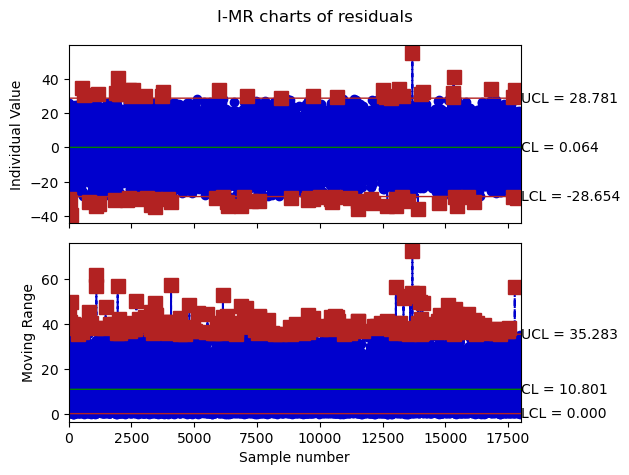

In [107]:
# Create a DataFrame for the residuals
df_SCC = pd.DataFrame(residual, columns=['residuals'])

# Plot the I-MR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'residuals')

In [108]:
# Extract the UCL from the MR chart
ucl = df_SCC_IMR['MR_UCL']

# Count the number of points in the MR chart that are above the UCL
points_over_ucl = (df_SCC_IMR['MR'] > ucl).sum()

print(f"Number of points over the UCL: {points_over_ucl}")

Number of points over the UCL: 204


In [109]:
from statsmodels.stats.stattools import durbin_watson

# Perform the Durbin-Watson test
dw_stat = durbin_watson(residual)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.9957472136743701


# Random Gapping

In [112]:
import numpy as np

def create_random_gapping(dataset, gap_size=(10, 10), target_dim=(60, 60)):
    gapped_dataset = []
    for layer in dataset:
        # Ensure the layer is at least the target size
        assert layer.shape[0] >= target_dim[0] and layer.shape[1] >= target_dim[1], "Layer size is smaller than target dimensions."
        
        # Randomly select the starting indices for the gap
        max_x = target_dim[0] - gap_size[0]
        max_y = target_dim[1] - gap_size[1]
        start_x = np.random.randint(0, max_x)
        start_y = np.random.randint(0, max_y)
        
        # Create a copy of the layer and apply the gap
        gapped_layer = layer[:target_dim[0], :target_dim[1]].copy()
        gapped_layer[start_x:start_x + gap_size[0], start_y:start_y + gap_size[1]] = np.nan
        
        gapped_dataset.append(gapped_layer)
    
    return np.array(gapped_dataset)

# Apply random gapping to list_25l
gap_size = (10, 10)  # Define the gap size
gapped_dataset = create_random_gapping(list_25l, gap_size=gap_size)
print(gapped_dataset.shape)
gapped_dataset

(25, 60, 60)


array([[[1597.6 , 1594.2 , 1583.8 , ..., 1572.9 , 1566.7 , 1574.2 ],
        [1592.9 , 1585.1 , 1583.85, ..., 1572.05, 1563.2 , 1571.5 ],
        [1593.55, 1579.9 , 1583.9 , ..., 1572.35, 1564.5 , 1574.5 ],
        ...,
        [1569.7 , 1567.5 , 1557.8 , ..., 1567.  , 1570.8 , 1566.95],
        [1569.1 , 1570.5 , 1558.45, ..., 1563.5 , 1564.5 , 1559.5 ],
        [1574.65, 1567.65, 1557.9 , ..., 1561.35, 1566.5 , 1563.2 ]],

       [[1556.6 , 1540.1 , 1535.85, ..., 1565.9 , 1575.5 , 1563.85],
        [1546.1 , 1555.8 , 1554.65, ..., 1559.25, 1563.55, 1555.6 ],
        [1557.1 , 1556.7 , 1544.75, ..., 1557.05, 1565.  , 1562.3 ],
        ...,
        [1575.7 , 1571.95, 1579.1 , ..., 1576.3 , 1550.8 , 1564.1 ],
        [1579.1 , 1591.4 , 1570.1 , ..., 1558.  , 1576.4 , 1573.9 ],
        [1574.6 , 1566.4 , 1575.2 , ..., 1568.85, 1559.55, 1550.6 ]],

       [[1584.5 , 1578.8 , 1587.7 , ..., 1552.75, 1557.35, 1571.1 ],
        [1577.5 , 1586.4 , 1580.  , ..., 1577.1 , 1558.9 , 1566.4 ],
    

In [113]:
total_points = random_sampled_dataset.size
print(f"Total number of points in the dataset: {total_points}")

Total number of points in the dataset: 90000


In [114]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the list_25l instead of the original dataset
X = []
y = []

for layer_index, pivot_table in enumerate(gapped_dataset):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = pd.DataFrame(X, columns=['layer_id', 'x', 'y'])
y = pd.Series(y, name='temp')
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
temp =  + 1565.436 const -0.175 layer_id -0.102 x -0.100 y

COEFFICIENTS
------------
    Term      Coef  SE Coef    T-Value     P-Value
   const 1565.4359   0.1440 10872.7622  0.0000e+00
layer_id   -0.1753   0.0064   -27.2600 6.0995e-163
       x   -0.1024   0.0027   -38.3530  0.0000e+00
       y   -0.0999   0.0027   -37.3739 2.5956e-303

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
13.7189 0.0391      0.039

ANALYSIS OF VARIANCE
---------------------
    Source      DF     Adj SS     Adj MS    F-Value     P-Value
Regression     3.0 6.6968e+05 2.2323e+05 1.1861e+03  0.0000e+00
     const     1.0 2.2250e+10 2.2250e+10 1.1822e+08  0.0000e+00
  layer_id     1.0 1.3986e+05 1.3986e+05 7.4311e+02 6.0995e-163
         x     1.0 2.7685e+05 2.7685e+05 1.4709e+03 3.6645e-319
         y     1.0 2.6289e+05 2.6289e+05 1.3968e+03 2.5956e-303
     Error 87496.0 1.6468e+07 1.8821e+02        NaN         NaN
     Total 87499.0 1.7137e+07        NaN      

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = []
y = []

for layer_index, pivot_table in enumerate(gapped_dataset):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse= mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 110.37344490270527


In [116]:
# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse}")

# Evaluate the model on the testing set
test_mse = mean_squared_error(y_test, y_pred)
print(f"Testing Mean Squared Error: {test_mse}")

# Calculate R-squared for the testing set
test_r = model.score(X_test, y_test)
print(f"Testing R-squared: {test_r}")

# Feature importance (specific to RandomForestRegressor)
feature_importances = model.feature_importances_
print(f"Feature Importances: {feature_importances}")

Training Mean Squared Error: 15.134442315954436
Testing Mean Squared Error: 110.37344490270527
Testing R-squared: 0.4357291163452387
Feature Importances: [0.3279 0.3449 0.3273]


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


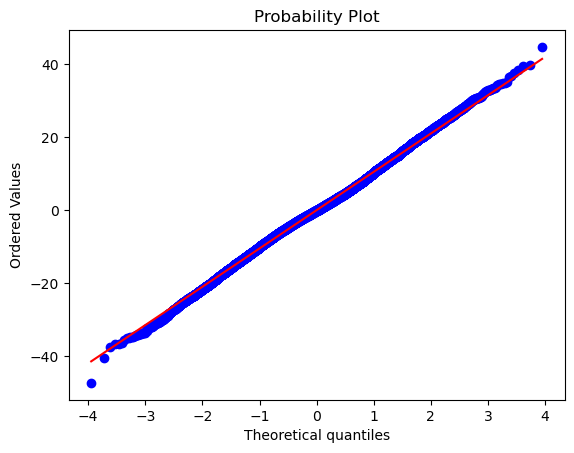

Shapiro-wilk test statistic = 0.998
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [117]:
residuals= y_test - y_pred
_=qda.Assumptions(residuals).normality()

In [118]:
print(residuals)

[17.5325 -1.867  15.056  ...  7.7505 12.3815  8.6185]


In [119]:
from scipy.stats import zscore

# Calculate the z-scores for the residuals
residuals_z_scores = zscore(residuals)

# Define a threshold for identifying outliers
z_threshold = 3

# Identify the indices of residuals that are outliers
outlier_indices = np.where(np.abs(residuals_z_scores) > z_threshold)[0]

# Print the outliers
print(f"Outlier Indices: {outlier_indices}")
print(f"Outlier Residuals: {residuals[outlier_indices]}")


Outlier Indices: [   36   316   395   426   447   668   964  1351  1543  1708  2083  2219
  2563  2845  2881  3271  3285  3521  3561  3993  4107  4244  4455  4542
  4672  4859  5049  5135  5228  5236  5264  5719  5930  6090  7122  7257
  7800  8671  8924  9036  9230  9729  9736 10009 10148 10631 10715 10753
 11012 11206 11325 11435 11734 12046 12419 12877 13208 13394 13946 14753
 14825 14864 15110 15689 15900 15983 16607 16767 16780 16809]
Outlier Residuals: [ 34.5755 -33.028  -36.7895 -34.7065 -34.1255  32.755  -31.852  -32.262
  32.806  -33.8115  34.7015 -35.443  -33.5755 -31.571   34.573   36.5885
  33.714   37.55    39.4615 -31.6365 -32.319  -47.3305  32.5675 -33.9815
 -33.5975 -31.9085 -34.0805  32.817   36.758   39.8155 -31.785   35.237
  32.4075  33.3375  32.0885 -37.4795  31.8985 -32.0115  33.304  -32.263
  33.1305  31.9075  32.6425 -34.807   44.714  -36.4635 -32.0665  32.9865
  34.9085 -33.591  -34.4435 -40.3945 -32.0735 -33.701   32.828  -35.1435
  32.2295  34.331  -35.1255  

In [120]:
# Identify the corresponding points in the dataset
corresponding_points = []

for index in range(len(residuals)):
    layer_index = int(X_test[index, 0])  # Get the layer index
    x_coord = int(X_test[index, 1])     # Get the x coordinate
    y_coord = int(X_test[index, 2])     # Get the y coordinate
    corresponding_points.append((layer_index, x_coord, y_coord))

# Print the corresponding points
print(f"Corresponding Points: {corresponding_points}")

Corresponding Points: [(2, 12, 57), (3, 42, 52), (18, 32, 11), (12, 51, 31), (21, 17, 28), (18, 51, 18), (13, 13, 8), (6, 15, 21), (22, 54, 53), (24, 59, 18), (21, 8, 6), (11, 53, 50), (12, 37, 52), (24, 36, 5), (11, 54, 35), (24, 27, 9), (13, 43, 4), (7, 31, 59), (11, 17, 55), (0, 41, 28), (14, 27, 7), (2, 2, 24), (22, 9, 52), (20, 16, 20), (7, 51, 51), (24, 15, 37), (0, 20, 45), (20, 22, 3), (4, 12, 7), (16, 59, 0), (5, 47, 42), (14, 15, 6), (10, 38, 36), (1, 28, 42), (15, 31, 0), (1, 3, 35), (1, 44, 8), (21, 31, 40), (6, 12, 49), (15, 46, 0), (7, 32, 35), (5, 39, 6), (3, 41, 1), (10, 7, 53), (9, 18, 41), (18, 41, 55), (9, 7, 13), (12, 57, 21), (19, 15, 59), (24, 22, 58), (15, 1, 36), (14, 19, 4), (14, 51, 57), (18, 4, 29), (4, 46, 56), (10, 39, 52), (1, 35, 38), (19, 7, 17), (2, 36, 52), (3, 53, 39), (17, 1, 20), (4, 35, 56), (13, 19, 41), (23, 39, 32), (21, 57, 7), (3, 44, 23), (2, 32, 12), (5, 43, 0), (18, 26, 29), (6, 5, 56), (4, 54, 10), (7, 39, 31), (10, 10, 35), (24, 45, 8), (

In [121]:
# Define the points to remove
points_to_remove = [(layer_index, x_coord, y_coord)]  # Replace with the actual points you want to remove

# Update the gapped_dataset by setting the specified points to np.nan
for layer_index, x, y in points_to_remove:
    gapped_dataset[layer_index, x, y] = np.nan

print("Specified points have been removed (set to NaN) in gapped_dataset.")

Specified points have been removed (set to NaN) in gapped_dataset.


In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = []
y = []

for layer_index, pivot_table in enumerate(gapped_dataset):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse= mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 111.19830266532185


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


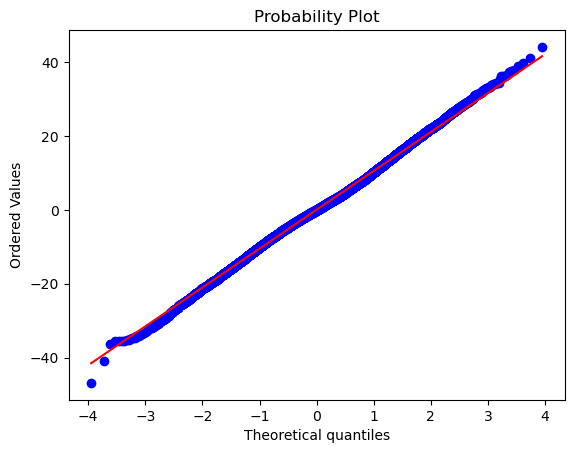

Shapiro-wilk test statistic = 0.998
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [123]:
residuals= y_test - y_pred
_=qda.Assumptions(residuals).normality()

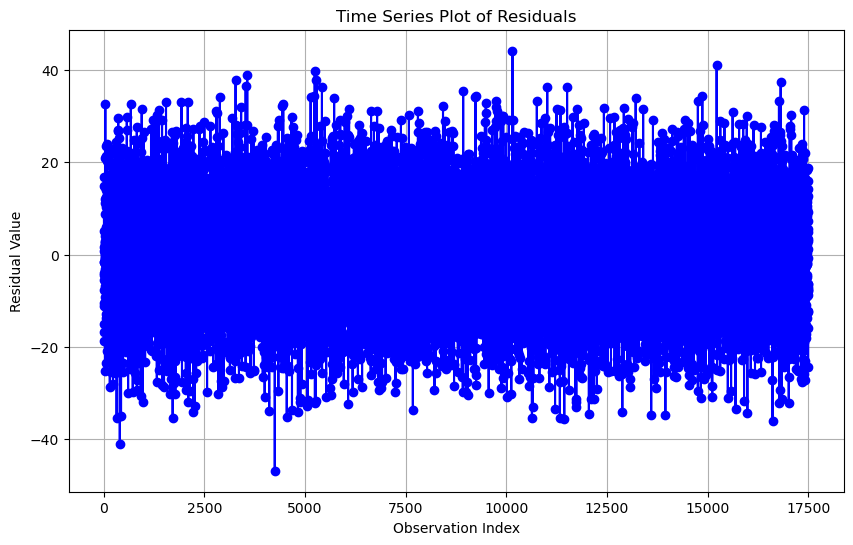

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(residuals) + 1), residuals, marker='o', linestyle='-', color='blue')
plt.title('Time Series Plot of Residuals')
plt.xlabel('Observation Index')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

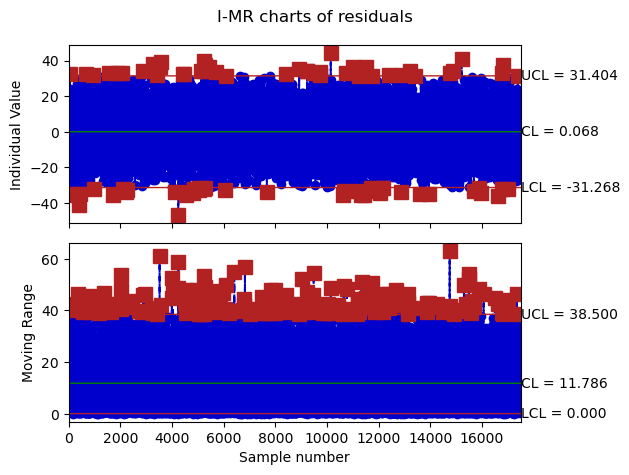

In [125]:
# Create a DataFrame for the residuals
df_SCC = pd.DataFrame(residuals, columns=['residuals'])

# Plot the I-MR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'residuals')

In [126]:
# Extract the UCL from the MR chart
ucl = df_SCC_IMR['MR_UCL']

# Count the number of points in the MR chart that are above the UCL
points_over_ucl = (df_SCC_IMR['MR'] > ucl).sum()

print(f"Number of points over the UCL: {points_over_ucl}")

Number of points over the UCL: 189


In [127]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result = anderson(residuals, dist='norm')

print("Anderson-Darling Test Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

# Interpret the result
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 16.399927121561632
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


In [128]:
from statsmodels.stats.stattools import durbin_watson

# Perform the Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.982948214627909
